The Purpose of this notebook is to create a dataset with labels and XGB Predictions so that we can use it for Stacking purposes.

In [1]:
BUCKET_NAME = "msil_raw"
FOLDER_NAME = "training_data"
TRAINFILE = "trainset.csv"
VALIDFILE = "validset.csv"
TESTFILE = "testset.csv"

In [2]:
import google.datalab.storage as storage
import pandas as pd
from io import BytesIO

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import time
from datetime import datetime
from scipy import integrate
import pickle

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# setting up the parameters
plt.rcParams["figure.figsize"] = (10, 10)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("precision", 15)
sns.set_style("darkgrid")

In [4]:
mybucket = storage.Bucket(BUCKET_NAME)
data_csv = mybucket.object(FOLDER_NAME + "/" + TRAINFILE)

uri = data_csv.uri
%gcs read --object $uri --variable data

trainset = pd.read_csv(BytesIO(data))
trainset.head()

,IMEI,Year,Month,Day,Hour,Minute,Seconds,tp,sp,EVVSP,EVVSP_delta,EVVSP_change,EVGPO,EVOAS,EVIGM_Latest,EVCOM_Latest,EVACO_Z,EVIRT_Min,EVDI2,EVBMI_Latest,EVBMA_Latest,EVVAC,EVVAC_delta,EVVAC_change,EVODO,EVODOH,EVSMA_EWMA,EVSMA_delta,EVSMA_in,combine
0,4,2018,11,15,7,9,39,1,0.0,53.250000000000000,0.0,0.0,0,20.0,25,38,-64.0,213,22,21.5,22.5,0.000000000000000,0.0,0.0,806,0.000000000000000,68.099999999999994,0.0,68.099999999999994,1263
1,4,2018,11,15,7,9,40,1,1000.0,51.492199999999997,0.0,0.0,0,20.0,25,38,-56.0,213,22,21.5,22.5,-4.882777777777787,0.0,0.0,806,0.014547527777778,68.099999999999994,0.0,68.099999999999994,1263
2,4,2018,11,15,7,9,41,1,2000.0,50.367199999999997,0.0,0.0,0,20.0,25,38,-36.0,213,22,21.5,22.5,-3.125000000000000,0.0,0.0,806,0.028694666666667,68.099999999999994,0.0,68.099999999999994,1263
3,4,2018,11,15,7,9,42,1,3000.0,48.804699999999997,0.0,0.0,0,20.0,25,38,-25.0,213,22,21.5,22.5,-4.340277777777780,0.0,0.0,806,0.042468541666667,68.099999999999994,0.0,68.099999999999994,1263
4,4,2018,11,15,7,9,43,1,4000.0,47.101599999999998,0.0,0.0,0,20.0,25,38,-72.0,213,22,21.5,22.5,-4.730833333333331,0.0,0.0,806,0.055788861111111,68.099999999999994,0.0,68.099999999999994,1263


In [5]:
# loading the model
model_train = pickle.load(open('model_xgb_stack_2.pickle.dat','rb'))

In [22]:
test_trip = trainset[trainset["combine"] == 2]

In [23]:
sma_absolute = test_trip["EVSMA_EWMA"].iloc[0]
print("SMA Absolute = {}".format(sma_absolute))

sma_actual = test_trip["EVSMA_EWMA"]

test_trip = test_trip.drop(columns = ["IMEI", "EVSMA_EWMA", "tp", "combine"])

x_test_trip = test_trip.drop(columns = ["EVSMA_delta"])
y_test_trip = test_trip["EVSMA_delta"]

SMA Absolute = 93.0


In [24]:
d_test_trip = xgb.DMatrix(x_test_trip)

In [25]:
predictions = model_train.predict(d_test_trip)

In [26]:
for i in range(0, len(predictions)):
  if predictions[i]<0:
    predictions[i]=0

In [27]:
# making a dataframe of actual and predicted values
test_trip_df = pd.DataFrame({
    "y": y_test_trip,
    "yhat": predictions
})

In [28]:
sma_list = []
for i in range(0, len(predictions)):
  temp_sma = sma_absolute - predictions[i]
  sma_list.append(temp_sma)
  sma_absolute = temp_sma

In [29]:
stacked_df = pd.DataFrame({
    "y": sma_actual,
    "yhat": sma_list
}).reset_index(drop = True)

In [30]:
stacked_df.head()

,y,yhat
0,93.0,92.999512761831284
1,93.0,92.999027460813522
2,93.0,92.998551100492477
3,93.0,92.998097628355026
4,93.0,92.997581630945206


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


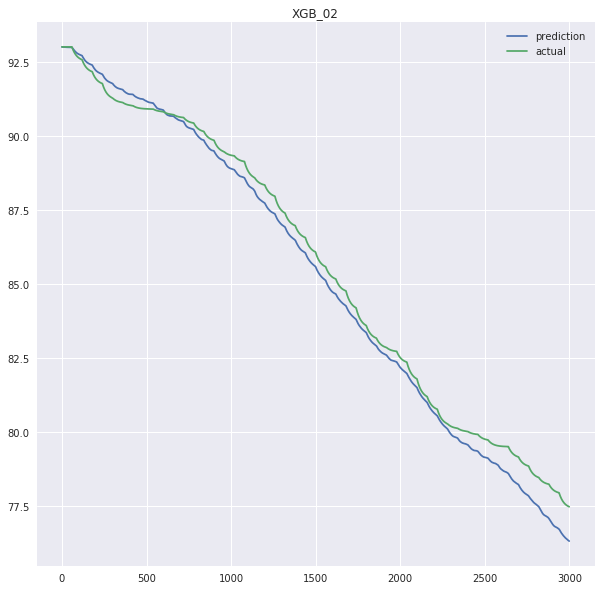

In [31]:
plt.plot(sma_list, label = "prediction")
plt.plot(list(sma_actual), label = "actual")
plt.title("XGB_02")
plt.legend()
plt.show()

In [32]:
mybucket = storage.Bucket(BUCKET_NAME)
data_csv = mybucket.object(FOLDER_NAME + "/" + "stacked_data_xgb.csv")

uri = data_csv.uri
%gcs read --object $uri --variable data

stacked_xgb = pd.read_csv(BytesIO(data))
stacked_xgb.head()

,y,yhat
0,71.900000000000006,71.899833226203924
1,71.900000000000006,71.899671489000326
2,71.900000000000006,71.899527961015707
3,71.900000000000006,71.899389499425908
4,71.900000000000006,71.899271988868719


In [33]:
len(stacked_df)

3000

In [34]:
stacked_df = pd.concat((stacked_xgb, stacked_df), axis = 0).reset_index(drop = True)

In [35]:
len(stacked_df)

5520

In [36]:
stacked_df.to_csv('stacked_data_xgb.csv', index = False)
!gsutil cp 'stacked_data_xgb.csv' 'gs://msil_raw/training_data/stacked_data_xgb.csv'
%gcs read --object gs://msil_raw/training_data/stacked_data_xgb.csv --variable stacked_data
df2 = pd.read_csv(BytesIO(stacked_data))

Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
- [1 files][192.0 KiB/192.0 KiB]                                                
Operation completed over 1 objects/192.0 KiB.                                    


In [6]:
for i in range(701, 1401):
  print("----------------------")
  test_trip = trainset[trainset["combine"] == i]
  print("Test Trip {}".format(i))
  sma_absolute = test_trip["EVSMA_EWMA"].iloc[0]
  print("SMA Absolute = {}".format(sma_absolute))

  sma_actual = test_trip["EVSMA_EWMA"]

  test_trip = test_trip.drop(columns = ["IMEI", "EVSMA_EWMA", "tp", "combine"])

  x_test_trip = test_trip.drop(columns = ["EVSMA_delta"])
  y_test_trip = test_trip["EVSMA_delta"]
  
  d_test_trip = xgb.DMatrix(x_test_trip)
  predictions = model_train.predict(d_test_trip)
  
  for i in range(0, len(predictions)):
    if predictions[i]<0:
      predictions[i]=0
      
  # making a dataframe of actual and predicted values
  test_trip_df = pd.DataFrame({
    "y": y_test_trip,
    "yhat": predictions
  })
  
  sma_list = []
  for i in range(0, len(predictions)):
    temp_sma = sma_absolute - predictions[i]
    sma_list.append(temp_sma)
    sma_absolute = temp_sma
    
  err = (((sma_list[-1] - list(sma_actual)[-1])))/(list(sma_actual)[0] - list(sma_actual)[-1])
  print("Error for the Trip = {:.2f} %".format(err * 100))
    
  stacked_df = pd.DataFrame({
    "y": sma_actual,
    "yhat": sma_list
  }).reset_index(drop = True)
  
  print("length of the test trip df = {}".format(len(stacked_df)))
  
  mybucket = storage.Bucket(BUCKET_NAME)
  data_csv = mybucket.object(FOLDER_NAME + "/" + "stacked_data_xgb.csv")
  uri = data_csv.uri
  %gcs read --object $uri --variable data
  stacked_xgb = pd.read_csv(BytesIO(data))

  print("Length of stacked DF length prior = {}".format(len(stacked_xgb)))
  
  stacked_df = pd.concat((stacked_xgb, stacked_df), axis = 0).reset_index(drop = True)
  
  print("Length of stacked DF length after = {}".format(len(stacked_df)))
  
  stacked_df.to_csv('stacked_data_xgb.csv', index = False)
  !gsutil cp 'stacked_data_xgb.csv' 'gs://msil_raw/training_data/stacked_data_xgb.csv'
  %gcs read --object gs://msil_raw/training_data/stacked_data_xgb.csv --variable stacked_data
  df2 = pd.read_csv(BytesIO(stacked_data))

----------------------
Test Trip 701
SMA Absolute = 85.6
Error for the Trip = 3.81 %
length of the test trip df = 7560
Length of stacked DF length prior = 1464143
Length of stacked DF length after = 1471703


Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 49.8 MiB/ 49.8 MiB]                                                
Operation completed over 1 objects/49.8 MiB.                                     
----------------------
Test Trip 702
SMA Absolute = 93.2
Error for the Trip = 4.24 %
length of the test trip df = 4740
Length of stacked DF length prior = 1471703
Length of stacked DF length after = 1476443
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 50.0 MiB/ 50.0 MiB]                                                
Operation completed over 1 objects/50.0 MiB.                                     
-------------------

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1516463
Length of stacked DF length after = 1516523
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 51.4 MiB/ 51.4 MiB]                                                
Operation completed over 1 objects/51.4 MiB.                                     
----------------------
Test Trip 714
SMA Absolute = 92.7
Error for the Trip = -6.17 %
length of the test trip df = 10680
Length of stacked DF length prior = 1516523
Length of stacked DF length after = 1527203
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 51.7 MiB/ 51.7 MiB]                                                
Operation completed over 1 objects/51.7 MiB.                                     
----------------------
Test Trip 715
SMA Absolute = 74.9
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1527203
Length of stacked DF length after = 1527263
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 51.7 MiB/ 51.7 MiB]                                                
Operation completed over 1 objects/51.7 MiB.                                     
----------------------
Test Trip 716
SMA Absolute = 76.3
Error for the Trip = 48.36 %
length of the test trip df = 180
Length of stacked DF length prior = 1527263
Length of stacked DF length after = 1527443
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 51.7 MiB/ 51.7 MiB]                                                
Operation completed over 1 objects/51.7 MiB.                                     
----------------------
Test Trip 717
SMA Absolute = 88.7
Error for the Trip = -1.70 %
length of the test trip df = 7500
Length of stacked DF length prior = 1527443
Length of stacked DF length after = 1534943
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1579343
Length of stacked DF length after = 1579403
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 53.5 MiB/ 53.5 MiB]                                                
Operation completed over 1 objects/53.5 MiB.                                     
----------------------
Test Trip 729
SMA Absolute = 89.8
Error for the Trip = -1.20 %
length of the test trip df = 5820
Length of stacked DF length prior = 1579403
Length of stacked DF length after = 1585223
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 53.7 MiB/ 53.7 MiB]                                                
Operation completed over 1 objects/53.7 MiB.                                     
----------------------
Test Trip 730
SMA Absolute = 48.2
Error for the Trip = 2.67 %
length of the test trip df = 1860
Length of stacked DF length prior = 1585223
Length of stacked DF length after = 1587083
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1616483
Length of stacked DF length after = 1616843
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 54.8 MiB/ 54.8 MiB]                                                
Operation completed over 1 objects/54.8 MiB.                                     
----------------------
Test Trip 739
SMA Absolute = 40.5
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1616843
Length of stacked DF length after = 1616903
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 54.8 MiB/ 54.8 MiB]                                                
Operation completed over 1 objects/54.8 MiB.                                     
----------------------
Test Trip 740
SMA Absolute = 40.4
Error for the Trip = -7554360934300.00 %
length of the test trip df = 60
Length of stacked DF length prior = 1616903
Length of stacked DF length after = 1616963
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 54.8 MiB/ 54.8 MiB]                                                
Operation completed over 1 objects/54.8 MiB.                                     
----------------------
Test Trip 741
SMA Absolute = 46.3
Error for the Trip = -23.31 %
length of the test trip df = 960
Length of stacked DF length prior = 1616963
Length of stacked DF length after = 1617923
Copying file://stacked_data_xgb.cs

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1632143
Length of stacked DF length after = 1632203
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 55.3 MiB/ 55.3 MiB]                                                
Operation completed over 1 objects/55.3 MiB.                                     
----------------------
Test Trip 745
SMA Absolute = 60.6
Error for the Trip = 3.29 %
length of the test trip df = 4080
Length of stacked DF length prior = 1632203
Length of stacked DF length after = 1636283
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 55.4 MiB/ 55.4 MiB]                                                
Operation completed over 1 objects/55.4 MiB.                                     
----------------------
Test Trip 746
SMA Absolute = 39.7
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1636283
Length of stacked DF length after = 1636343
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 55.4 MiB/ 55.4 MiB]                                                
Operation completed over 1 objects/55.4 MiB.                                     
----------------------
Test Trip 747
SMA Absolute = 39.7
Error for the Trip = -161.29 %
length of the test trip df = 600
Length of stacked DF length prior = 1636343
Length of stacked DF length after = 1636943
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 55.5 MiB/ 55.5 MiB]                                                
Operation completed over 1 objects/55.5 MiB.                                     
----------------------
Test Trip 748
SMA Absolute = 41.2
Error for the Trip = -241523123814300.00 %
length of the test trip df = 240
Length of stacked DF length prior = 1636943
Length of stacked DF length after = 1637183
Copying file://stacked_data_xg

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1643483
Length of stacked DF length after = 1643963
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 55.7 MiB/ 55.7 MiB]                                                
Operation completed over 1 objects/55.7 MiB.                                     
----------------------
Test Trip 752
SMA Absolute = 79.9
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1643963
Length of stacked DF length after = 1644023
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 55.7 MiB/ 55.7 MiB]                                                
Operation completed over 1 objects/55.7 MiB.                                     
----------------------
Test Trip 753
SMA Absolute = 79.9
Error for the Trip = -inf %
length of the test trip df = 360


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1644023
Length of stacked DF length after = 1644383
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 55.7 MiB/ 55.7 MiB]                                                
Operation completed over 1 objects/55.7 MiB.                                     
----------------------
Test Trip 754
SMA Absolute = 84.2
Error for the Trip = 2.88 %
length of the test trip df = 8040
Length of stacked DF length prior = 1644383
Length of stacked DF length after = 1652423
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.0 MiB/ 56.0 MiB]                                                
Operation completed over 1 objects/56.0 MiB.                                     
----------------------
Test Trip 755
SMA Absolute = 93.3
Error for the Trip = -4104653688012700.00 %
length of the test trip df = 480
Length of stacked DF length prior = 1652423
Length of stacked DF length after = 1652903
Copying file://stacked_data_xgb

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1657019
Length of stacked DF length after = 1657139
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.1 MiB/ 56.1 MiB]                                                
Operation completed over 1 objects/56.1 MiB.                                     
----------------------
Test Trip 758
SMA Absolute = 90.6
Error for the Trip = -0.23 %
length of the test trip df = 8580
Length of stacked DF length prior = 1657139
Length of stacked DF length after = 1665719
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.4 MiB/ 56.4 MiB]                                                
Operation completed over 1 objects/56.4 MiB.                                     
----------------------
Test Trip 759
SMA Absolute = 72.1
Error for the Trip = -1317.52 %
length of the test trip df = 2280
Length of stacked DF length prior = 1665719
Length of stacked DF length after = 1667999
Copying file://stacked_data_xgb.csv [Cont

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1667999
Length of stacked DF length after = 1668119
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.5 MiB/ 56.5 MiB]                                                
Operation completed over 1 objects/56.5 MiB.                                     
----------------------
Test Trip 761
SMA Absolute = 72.1
Error for the Trip = -inf %
length of the test trip df = 120


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1668119
Length of stacked DF length after = 1668239
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.5 MiB/ 56.5 MiB]                                                
Operation completed over 1 objects/56.5 MiB.                                     
----------------------
Test Trip 762
SMA Absolute = 71.8
Error for the Trip = 2.90 %
length of the test trip df = 2520
Length of stacked DF length prior = 1668239
Length of stacked DF length after = 1670759
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.6 MiB/ 56.6 MiB]                                                
Operation completed over 1 objects/56.6 MiB.                                     
----------------------
Test Trip 763
SMA Absolute = 44.0
Error for the Trip = -5.47 %
length of the test trip df = 2460
Length of stacked DF length prior = 1670759
Length of stacked DF length after = 1673219
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1673219
Length of stacked DF length after = 1673279
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.7 MiB/ 56.7 MiB]                                                
Operation completed over 1 objects/56.7 MiB.                                     
----------------------
Test Trip 765
SMA Absolute = 81.7
Error for the Trip = -5.12 %
length of the test trip df = 4740
Length of stacked DF length prior = 1673279
Length of stacked DF length after = 1678019
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.8 MiB/ 56.8 MiB]                                                
Operation completed over 1 objects/56.8 MiB.                                     
----------------------
Test Trip 766
SMA Absolute = 61.9
Error for the Trip = -10.49 %
length of the test trip df = 3240
Length of stacked DF length prior = 1678019
Length of stacked DF length after = 1681259
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1681259
Length of stacked DF length after = 1681379
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.9 MiB/ 56.9 MiB]                                                
Operation completed over 1 objects/56.9 MiB.                                     
----------------------
Test Trip 768
SMA Absolute = 93.3
Error for the Trip = -23.45 %
length of the test trip df = 359
Length of stacked DF length prior = 1681379
Length of stacked DF length after = 1681738
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.9 MiB/ 56.9 MiB]                                                
Operation completed over 1 objects/56.9 MiB.                                     
----------------------
Test Trip 769
SMA Absolute = 39.7
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1681738
Length of stacked DF length after = 1681798
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.9 MiB/ 56.9 MiB]                                                
Operation completed over 1 objects/56.9 MiB.                                     
----------------------
Test Trip 770
SMA Absolute = 39.7
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1681798
Length of stacked DF length after = 1681858
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.9 MiB/ 56.9 MiB]                                                
Operation completed over 1 objects/56.9 MiB.                                     
----------------------
Test Trip 771
SMA Absolute = 39.6
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1681858
Length of stacked DF length after = 1681918
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.9 MiB/ 56.9 MiB]                                                
Operation completed over 1 objects/56.9 MiB.                                     
----------------------
Test Trip 772
SMA Absolute = 39.6
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1681918
Length of stacked DF length after = 1681978
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.9 MiB/ 56.9 MiB]                                                
Operation completed over 1 objects/56.9 MiB.                                     
----------------------
Test Trip 773
SMA Absolute = 39.6
Error for the Trip = -inf %
length of the test trip df = 120


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1681978
Length of stacked DF length after = 1682098
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 56.9 MiB/ 56.9 MiB]                                                
Operation completed over 1 objects/56.9 MiB.                                     
----------------------
Test Trip 774
SMA Absolute = 41.5
Error for the Trip = -7.90 %
length of the test trip df = 300
Length of stacked DF length prior = 1682098
Length of stacked DF length after = 1682398
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 57.0 MiB/ 57.0 MiB]                                                
Operation completed over 1 objects/57.0 MiB.                                     
----------------------
Test Trip 775
SMA Absolute = 92.5
Error for the Trip = -137.63 %
length of the test trip df = 120
Length of stacked DF length prior = 1682398
Length of stacked DF length after = 1682518
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1697817
Length of stacked DF length after = 1697877
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 57.5 MiB/ 57.5 MiB]                                                
Operation completed over 1 objects/57.5 MiB.                                     
----------------------
Test Trip 780
SMA Absolute = 39.9
Error for the Trip = -46.08 %
length of the test trip df = 240
Length of stacked DF length prior = 1697877
Length of stacked DF length after = 1698117
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 57.5 MiB/ 57.5 MiB]                                                
Operation completed over 1 objects/57.5 MiB.                                     
----------------------
Test Trip 781
SMA Absolute = 39.7
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1698117
Length of stacked DF length after = 1698177
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 57.5 MiB/ 57.5 MiB]                                                
Operation completed over 1 objects/57.5 MiB.                                     
----------------------
Test Trip 782
SMA Absolute = 39.7
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1698177
Length of stacked DF length after = 1698237
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 57.5 MiB/ 57.5 MiB]                                                
Operation completed over 1 objects/57.5 MiB.                                     
----------------------
Test Trip 783
SMA Absolute = 94.0
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1698237
Length of stacked DF length after = 1698297
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 57.5 MiB/ 57.5 MiB]                                                
Operation completed over 1 objects/57.5 MiB.                                     
----------------------
Test Trip 784
SMA Absolute = 94.0
Error for the Trip = -inf %
length of the test trip df = 180


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1698297
Length of stacked DF length after = 1698477
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 57.5 MiB/ 57.5 MiB]                                                
Operation completed over 1 objects/57.5 MiB.                                     
----------------------
Test Trip 785
SMA Absolute = 93.7
Error for the Trip = 1.44 %
length of the test trip df = 6300
Length of stacked DF length prior = 1698477
Length of stacked DF length after = 1704777
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 57.7 MiB/ 57.7 MiB]                                                
Operation completed over 1 objects/57.7 MiB.                                     
----------------------
Test Trip 786
SMA Absolute = 89.4
Error for the Trip = 0.63 %
length of the test trip df = 5280
Length of stacked DF length prior = 1704777
Length of stacked DF length after = 1710057
Copying file://stacked_data_xgb.csv [Content-T

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1726377
Length of stacked DF length after = 1726856
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 58.5 MiB/ 58.5 MiB]                                                
Operation completed over 1 objects/58.5 MiB.                                     
----------------------
Test Trip 792
SMA Absolute = 72.0
Error for the Trip = -inf %
length of the test trip df = 1140


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1726856
Length of stacked DF length after = 1727996
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 58.5 MiB/ 58.5 MiB]                                                
Operation completed over 1 objects/58.5 MiB.                                     
----------------------
Test Trip 793
SMA Absolute = 83.5
Error for the Trip = -193.69 %
length of the test trip df = 180
Length of stacked DF length prior = 1727996
Length of stacked DF length after = 1728176
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 58.5 MiB/ 58.5 MiB]                                                
Operation completed over 1 objects/58.5 MiB.                                     
----------------------
Test Trip 794
SMA Absolute = 81.8
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1728176
Length of stacked DF length after = 1728236
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 58.5 MiB/ 58.5 MiB]                                                
Operation completed over 1 objects/58.5 MiB.                                     
----------------------
Test Trip 795
SMA Absolute = 94.6
Error for the Trip = -4.12 %
length of the test trip df = 10380
Length of stacked DF length prior = 1728236
Length of stacked DF length after = 1738616
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 58.8 MiB/ 58.8 MiB]                                                
Operation completed over 1 objects/58.8 MiB.                                     
----------------------
Test Trip 796
SMA Absolute = 91.2
Error for the Trip = 1.12 %
length of the test trip df = 7440
Length of stacked DF length prior = 1738616
Length of stacked DF length after = 1746056
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1790035
Length of stacked DF length after = 1790095
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 60.6 MiB/ 60.6 MiB]                                                
Operation completed over 1 objects/60.6 MiB.                                     
----------------------
Test Trip 813
SMA Absolute = 61.0
Error for the Trip = -14.41 %
length of the test trip df = 1080
Length of stacked DF length prior = 1790095
Length of stacked DF length after = 1791175
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 60.6 MiB/ 60.6 MiB]                                                
Operation completed over 1 objects/60.6 MiB.                                     
----------------------
Test Trip 814
SMA Absolute = 57.8
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1791175
Length of stacked DF length after = 1791235
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 60.6 MiB/ 60.6 MiB]                                                
Operation completed over 1 objects/60.6 MiB.                                     
----------------------
Test Trip 815
SMA Absolute = 74.1
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1791235
Length of stacked DF length after = 1791295
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 60.6 MiB/ 60.6 MiB]                                                
Operation completed over 1 objects/60.6 MiB.                                     
----------------------
Test Trip 816
SMA Absolute = 90.0
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1791295
Length of stacked DF length after = 1791355
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 60.6 MiB/ 60.6 MiB]                                                
Operation completed over 1 objects/60.6 MiB.                                     
----------------------
Test Trip 817
SMA Absolute = 89.1
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1791355
Length of stacked DF length after = 1791415
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 60.6 MiB/ 60.6 MiB]                                                
Operation completed over 1 objects/60.6 MiB.                                     
----------------------
Test Trip 818
SMA Absolute = 88.5
Error for the Trip = 0.56 %
length of the test trip df = 5340
Length of stacked DF length prior = 1791415
Length of stacked DF length after = 1796755
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 60.8 MiB/ 60.8 MiB]                                                
Operation completed over 1 objects/60.8 MiB.                                     
----------------------
Test Trip 819
SMA Absolute = 92.1
Error for the Trip = -1.82 %
length of the test trip df = 8760
Length of stacked DF length prior = 1796755
Length of stacked DF length after = 1805515
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1853395
Length of stacked DF length after = 1853455
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 62.7 MiB/ 62.7 MiB]                                                
Operation completed over 1 objects/62.7 MiB.                                     
----------------------
Test Trip 837
SMA Absolute = 90.4
Error for the Trip = -3.13 %
length of the test trip df = 2880
Length of stacked DF length prior = 1853455
Length of stacked DF length after = 1856335
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 62.8 MiB/ 62.8 MiB]                                                
Operation completed over 1 objects/62.8 MiB.                                     
----------------------
Test Trip 838
SMA Absolute = 79.7
Error for the Trip = -24.14 %
length of the test trip df = 2640
Length of stacked DF length prior = 1856335
Length of stacked DF length after = 1858975
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1859995
Length of stacked DF length after = 1860055
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.0 MiB/ 63.0 MiB]                                                
Operation completed over 1 objects/63.0 MiB.                                     
----------------------
Test Trip 841
SMA Absolute = 90.9
Error for the Trip = 17.19 %
length of the test trip df = 3660
Length of stacked DF length prior = 1860055
Length of stacked DF length after = 1863715
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.1 MiB/ 63.1 MiB]                                                
Operation completed over 1 objects/63.1 MiB.                                     
----------------------
Test Trip 842
SMA Absolute = 71.0
Error for the Trip = 5.48 %
length of the test trip df = 3300
Length of stacked DF length prior = 1863715
Length of stacked DF length after = 1867015
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1867975
Length of stacked DF length after = 1868035
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.2 MiB/ 63.2 MiB]                                                
Operation completed over 1 objects/63.2 MiB.                                     
----------------------
Test Trip 845
SMA Absolute = 89.9
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1868035
Length of stacked DF length after = 1868095
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.2 MiB/ 63.2 MiB]                                                
Operation completed over 1 objects/63.2 MiB.                                     
----------------------
Test Trip 846
SMA Absolute = 54.2
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1868095
Length of stacked DF length after = 1868155
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.2 MiB/ 63.2 MiB]                                                
Operation completed over 1 objects/63.2 MiB.                                     
----------------------
Test Trip 847
SMA Absolute = 92.5
Error for the Trip = -5.42 %
length of the test trip df = 2820
Length of stacked DF length prior = 1868155
Length of stacked DF length after = 1870975
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.3 MiB/ 63.3 MiB]                                                
Operation completed over 1 objects/63.3 MiB.                                     
----------------------
Test Trip 848
SMA Absolute = 78.0
Error for the Trip = -9.30 %
length of the test trip df = 2520
Length of stacked DF length prior = 1870975
Length of stacked DF length after = 1873495
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1874935
Length of stacked DF length after = 1874995
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.5 MiB/ 63.5 MiB]                                                
Operation completed over 1 objects/63.5 MiB.                                     
----------------------
Test Trip 851
SMA Absolute = 90.1
Error for the Trip = -9.98 %
length of the test trip df = 6119
Length of stacked DF length prior = 1874995
Length of stacked DF length after = 1881114
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.7 MiB/ 63.7 MiB]                                                
Operation completed over 1 objects/63.7 MiB.                                     
----------------------
Test Trip 852
SMA Absolute = 59.8
Error for the Trip = -96.88 %
length of the test trip df = 360
Length of stacked DF length prior = 1881114
Length of stacked DF length after = 1881474
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1881474
Length of stacked DF length after = 1881714
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.7 MiB/ 63.7 MiB]                                                
Operation completed over 1 objects/63.7 MiB.                                     
----------------------
Test Trip 854
SMA Absolute = 91.1
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1881714
Length of stacked DF length after = 1881774
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.7 MiB/ 63.7 MiB]                                                
Operation completed over 1 objects/63.7 MiB.                                     
----------------------
Test Trip 855
SMA Absolute = 91.0
Error for the Trip = 3.35 %
length of the test trip df = 3239
Length of stacked DF length prior = 1881774
Length of stacked DF length after = 1885013
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.8 MiB/ 63.8 MiB]                                                
Operation completed over 1 objects/63.8 MiB.                                     
----------------------
Test Trip 856
SMA Absolute = 77.1
Error for the Trip = -4.57 %
length of the test trip df = 3180
Length of stacked DF length prior = 1885013
Length of stacked DF length after = 1888193
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1888193
Length of stacked DF length after = 1888373
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.9 MiB/ 63.9 MiB]                                                
Operation completed over 1 objects/63.9 MiB.                                     
----------------------
Test Trip 858
SMA Absolute = 93.5
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1888373
Length of stacked DF length after = 1888433
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 63.9 MiB/ 63.9 MiB]                                                
Operation completed over 1 objects/63.9 MiB.                                     
----------------------
Test Trip 859
SMA Absolute = 76.1
Error for the Trip = -12.13 %
length of the test trip df = 2700
Length of stacked DF length prior = 1888433
Length of stacked DF length after = 1891133
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 64.0 MiB/ 64.0 MiB]                                                
Operation completed over 1 objects/64.0 MiB.                                     
----------------------
Test Trip 860
SMA Absolute = 89.9
Error for the Trip = 15.55 %
length of the test trip df = 2880
Length of stacked DF length prior = 1891133
Length of stacked DF length after = 1894013
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1898513
Length of stacked DF length after = 1898573
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 64.2 MiB/ 64.2 MiB]                                                
Operation completed over 1 objects/64.2 MiB.                                     
----------------------
Test Trip 866
SMA Absolute = 92.3
Error for the Trip = -1.37 %
length of the test trip df = 1800
Length of stacked DF length prior = 1898573
Length of stacked DF length after = 1900373
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 64.3 MiB/ 64.3 MiB]                                                
Operation completed over 1 objects/64.3 MiB.                                     
----------------------
Test Trip 867
SMA Absolute = 82.7
Error for the Trip = 13.06 %
length of the test trip df = 900
Length of stacked DF length prior = 1900373
Length of stacked DF length after = 1901273
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1910297
Length of stacked DF length after = 1910357
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 64.6 MiB/ 64.6 MiB]                                                
Operation completed over 1 objects/64.6 MiB.                                     
----------------------
Test Trip 872
SMA Absolute = 90.9
Error for the Trip = -3.99 %
length of the test trip df = 6300
Length of stacked DF length prior = 1910357
Length of stacked DF length after = 1916657
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 64.9 MiB/ 64.9 MiB]                                                
Operation completed over 1 objects/64.9 MiB.                                     
----------------------
Test Trip 873
SMA Absolute = 58.2
Error for the Trip = -233.20 %
length of the test trip df = 360
Length of stacked DF length prior = 1916657
Length of stacked DF length after = 1917017
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1930037
Length of stacked DF length after = 1930097
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.3 MiB/ 65.3 MiB]                                                
Operation completed over 1 objects/65.3 MiB.                                     
----------------------
Test Trip 880
SMA Absolute = 92.0
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1930097
Length of stacked DF length after = 1930157
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.3 MiB/ 65.3 MiB]                                                
Operation completed over 1 objects/65.3 MiB.                                     
----------------------
Test Trip 881
SMA Absolute = 91.9
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1930157
Length of stacked DF length after = 1930217
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.3 MiB/ 65.3 MiB]                                                
Operation completed over 1 objects/65.3 MiB.                                     
----------------------
Test Trip 882
SMA Absolute = 91.9
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1930217
Length of stacked DF length after = 1930277
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.3 MiB/ 65.3 MiB]                                                
Operation completed over 1 objects/65.3 MiB.                                     
----------------------
Test Trip 883
SMA Absolute = 91.9
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1930277
Length of stacked DF length after = 1930337
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.3 MiB/ 65.3 MiB]                                                
Operation completed over 1 objects/65.3 MiB.                                     
----------------------
Test Trip 884
SMA Absolute = 91.9
Error for the Trip = -3.74 %
length of the test trip df = 240
Length of stacked DF length prior = 1930337
Length of stacked DF length after = 1930577
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.3 MiB/ 65.3 MiB]                                                
Operation completed over 1 objects/65.3 MiB.                                     
----------------------
Test Trip 885
SMA Absolute = 90.6
Error for the Trip = 24.11 %
length of the test trip df = 300
Length of stacked DF length prior = 1930577
Length of stacked DF length after = 1930877
Copying file://stacked_data_xgb.csv [Content-T

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1939697
Length of stacked DF length after = 1939757
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.6 MiB/ 65.6 MiB]                                                
Operation completed over 1 objects/65.6 MiB.                                     
----------------------
Test Trip 891
SMA Absolute = 92.4
Error for the Trip = 5.16 %
length of the test trip df = 240
Length of stacked DF length prior = 1939757
Length of stacked DF length after = 1939997
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.6 MiB/ 65.6 MiB]                                                
Operation completed over 1 objects/65.6 MiB.                                     
----------------------
Test Trip 892
SMA Absolute = 91.9
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1939997
Length of stacked DF length after = 1940057
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.6 MiB/ 65.6 MiB]                                                
Operation completed over 1 objects/65.6 MiB.                                     
----------------------
Test Trip 893
SMA Absolute = 89.8
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1940057
Length of stacked DF length after = 1940117
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.6 MiB/ 65.6 MiB]                                                
Operation completed over 1 objects/65.6 MiB.                                     
----------------------
Test Trip 894
SMA Absolute = 91.2
Error for the Trip = 2.27 %
length of the test trip df = 5396
Length of stacked DF length prior = 1940117
Length of stacked DF length after = 1945513
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 65.8 MiB/ 65.8 MiB]                                                
Operation completed over 1 objects/65.8 MiB.                                     
----------------------
Test Trip 895
SMA Absolute = 84.9
Error for the Trip = -1.96 %
length of the test trip df = 3480
Length of stacked DF length prior = 1945513
Length of stacked DF length after = 1948993
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 1952646
Length of stacked DF length after = 1952706
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 66.1 MiB/ 66.1 MiB]                                                
Operation completed over 1 objects/66.1 MiB.                                     
----------------------
Test Trip 899
SMA Absolute = 89.8
Error for the Trip = -6.50 %
length of the test trip df = 2580
Length of stacked DF length prior = 1952706
Length of stacked DF length after = 1955286
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 66.2 MiB/ 66.2 MiB]                                                
Operation completed over 1 objects/66.2 MiB.                                     
----------------------
Test Trip 900
SMA Absolute = 74.8
Error for the Trip = 3.33 %
length of the test trip df = 3360
Length of stacked DF length prior = 1955286
Length of stacked DF length after = 1958646
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1958646
Length of stacked DF length after = 1958766
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 66.3 MiB/ 66.3 MiB]                                                
Operation completed over 1 objects/66.3 MiB.                                     
----------------------
Test Trip 902
SMA Absolute = 41.7
Error for the Trip = 4.17 %
length of the test trip df = 480
Length of stacked DF length prior = 1958766
Length of stacked DF length after = 1959246
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 66.3 MiB/ 66.3 MiB]                                                
Operation completed over 1 objects/66.3 MiB.                                     
----------------------
Test Trip 903
SMA Absolute = 89.5
Error for the Trip = -8872900315328.57 %
length of the test trip df = 60
Length of stacked DF length prior = 1959246
Length of stacked DF length after = 1959306
Copying file://stacked_data_xgb.csv 

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1974186
Length of stacked DF length after = 1974246
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 66.8 MiB/ 66.8 MiB]                                                
Operation completed over 1 objects/66.8 MiB.                                     
----------------------
Test Trip 909
SMA Absolute = 89.6
Error for the Trip = 26.95 %
length of the test trip df = 900
Length of stacked DF length prior = 1974246
Length of stacked DF length after = 1975146
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 66.8 MiB/ 66.8 MiB]                                                
Operation completed over 1 objects/66.8 MiB.                                     
----------------------
Test Trip 910
SMA Absolute = 93.7
Error for the Trip = -inf %
length of the test trip df = 240


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1975146
Length of stacked DF length after = 1975386
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 66.8 MiB/ 66.8 MiB]                                                
Operation completed over 1 objects/66.8 MiB.                                     
----------------------
Test Trip 911
SMA Absolute = 91.5
Error for the Trip = 1.97 %
length of the test trip df = 3240
Length of stacked DF length prior = 1975386
Length of stacked DF length after = 1978626
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 66.9 MiB/ 66.9 MiB]                                                
Operation completed over 1 objects/66.9 MiB.                                     
----------------------
Test Trip 912
SMA Absolute = 73.7
Error for the Trip = 2.68 %
length of the test trip df = 3720
Length of stacked DF length prior = 1978626
Length of stacked DF length after = 1982346
Copying file://stacked_data_xgb.csv [Content-T

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 1986486
Length of stacked DF length after = 1986546
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 67.2 MiB/ 67.2 MiB]                                                
Operation completed over 1 objects/67.2 MiB.                                     
----------------------
Test Trip 915
SMA Absolute = 93.4
Error for the Trip = -0.57 %
length of the test trip df = 5520
Length of stacked DF length prior = 1986546
Length of stacked DF length after = 1992066
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 67.4 MiB/ 67.4 MiB]                                                
Operation completed over 1 objects/67.4 MiB.                                     
----------------------
Test Trip 916
SMA Absolute = 42.7
Error for the Trip = 16.67 %
length of the test trip df = 540
Length of stacked DF length prior = 1992066
Length of stacked DF length after = 1992606
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2016570
Length of stacked DF length after = 2017050
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 68.2 MiB/ 68.2 MiB]                                                
Operation completed over 1 objects/68.2 MiB.                                     
----------------------
Test Trip 925
SMA Absolute = 82.7
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2017050
Length of stacked DF length after = 2017110
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 68.2 MiB/ 68.2 MiB]                                                
Operation completed over 1 objects/68.2 MiB.                                     
----------------------
Test Trip 926
SMA Absolute = 82.1
Error for the Trip = -141.68 %
length of the test trip df = 420
Length of stacked DF length prior = 2017110
Length of stacked DF length after = 2017530
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 68.3 MiB/ 68.3 MiB]                                                
Operation completed over 1 objects/68.3 MiB.                                     
----------------------
Test Trip 927
SMA Absolute = 48.7
Error for the Trip = -inf %
length of the test trip df = 178


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2017530
Length of stacked DF length after = 2017708
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 68.3 MiB/ 68.3 MiB]                                                
Operation completed over 1 objects/68.3 MiB.                                     
----------------------
Test Trip 928
SMA Absolute = 48.6
Error for the Trip = -15.28 %
length of the test trip df = 420
Length of stacked DF length prior = 2017708
Length of stacked DF length after = 2018128
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 68.3 MiB/ 68.3 MiB]                                                
Operation completed over 1 objects/68.3 MiB.                                     
----------------------
Test Trip 929
SMA Absolute = 47.2
Error for the Trip = -inf %
length of the test trip df = 536


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2018128
Length of stacked DF length after = 2018664
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 68.3 MiB/ 68.3 MiB]                                                
Operation completed over 1 objects/68.3 MiB.                                     
----------------------
Test Trip 930
SMA Absolute = 93.4
Error for the Trip = -1.03 %
length of the test trip df = 4618
Length of stacked DF length prior = 2018664
Length of stacked DF length after = 2023282
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 68.4 MiB/ 68.4 MiB]                                                
Operation completed over 1 objects/68.4 MiB.                                     
----------------------
Test Trip 931
SMA Absolute = 89.6
Error for the Trip = -4.31 %
length of the test trip df = 3840
Length of stacked DF length prior = 2023282
Length of stacked DF length after = 2027122
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2036062
Length of stacked DF length after = 2036122
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 68.9 MiB/ 68.9 MiB]                                                
Operation completed over 1 objects/68.9 MiB.                                     
----------------------
Test Trip 936
SMA Absolute = 92.4
Error for the Trip = -2.63 %
length of the test trip df = 3359
Length of stacked DF length prior = 2036122
Length of stacked DF length after = 2039481
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 69.0 MiB/ 69.0 MiB]                                                
Operation completed over 1 objects/69.0 MiB.                                     
----------------------
Test Trip 937
SMA Absolute = 73.4
Error for the Trip = 4.75 %
length of the test trip df = 3180
Length of stacked DF length prior = 2039481
Length of stacked DF length after = 2042661
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2069780
Length of stacked DF length after = 2069960
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 70.0 MiB/ 70.0 MiB]                                                
Operation completed over 1 objects/70.0 MiB.                                     
----------------------
Test Trip 945
SMA Absolute = 89.5
Error for the Trip = -2.69 %
length of the test trip df = 2700
Length of stacked DF length prior = 2069960
Length of stacked DF length after = 2072660
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 70.1 MiB/ 70.1 MiB]                                                
Operation completed over 1 objects/70.1 MiB.                                     
----------------------
Test Trip 946
SMA Absolute = 73.9
Error for the Trip = 5.58 %
length of the test trip df = 1499
Length of stacked DF length prior = 2072660
Length of stacked DF length after = 2074159
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2075539
Length of stacked DF length after = 2075599
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 70.2 MiB/ 70.2 MiB]                                                
Operation completed over 1 objects/70.2 MiB.                                     
----------------------
Test Trip 949
SMA Absolute = 91.9
Error for the Trip = 5.60 %
length of the test trip df = 4080
Length of stacked DF length prior = 2075599
Length of stacked DF length after = 2079679
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 70.3 MiB/ 70.3 MiB]                                                
Operation completed over 1 objects/70.3 MiB.                                     
----------------------
Test Trip 950
SMA Absolute = 64.8
Error for the Trip = 14.45 %
length of the test trip df = 1560
Length of stacked DF length prior = 2079679
Length of stacked DF length after = 2081239
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2089699
Length of stacked DF length after = 2089819
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 70.7 MiB/ 70.7 MiB]                                                
Operation completed over 1 objects/70.7 MiB.                                     
----------------------
Test Trip 954
SMA Absolute = 91.7
Error for the Trip = -0.81 %
length of the test trip df = 4260
Length of stacked DF length prior = 2089819
Length of stacked DF length after = 2094079
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 70.8 MiB/ 70.8 MiB]                                                
Operation completed over 1 objects/70.8 MiB.                                     
----------------------
Test Trip 955
SMA Absolute = 74.1
Error for the Trip = -22.17 %
length of the test trip df = 2699
Length of stacked DF length prior = 2094079
Length of stacked DF length after = 2096778
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2101156
Length of stacked DF length after = 2101276
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 71.1 MiB/ 71.1 MiB]                                                
Operation completed over 1 objects/71.1 MiB.                                     
----------------------
Test Trip 958
SMA Absolute = 90.9
Error for the Trip = -3.55 %
length of the test trip df = 6240
Length of stacked DF length prior = 2101276
Length of stacked DF length after = 2107516
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 71.3 MiB/ 71.3 MiB]                                                
Operation completed over 1 objects/71.3 MiB.                                     
----------------------
Test Trip 959
SMA Absolute = 89.5
Error for the Trip = -5825618622071.43 %
length of the test trip df = 60
Length of stacked DF length prior = 2107516
Length of stacked DF length after = 2107576
Copying file://stacked_data_xgb.cs

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 2127616
Length of stacked DF length after = 2127676
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 72.0 MiB/ 72.0 MiB]                                                
Operation completed over 1 objects/72.0 MiB.                                     
----------------------
Test Trip 968
SMA Absolute = 92.2
Error for the Trip = -2.24 %
length of the test trip df = 7620
Length of stacked DF length prior = 2127676
Length of stacked DF length after = 2135296
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 72.2 MiB/ 72.2 MiB]                                                
Operation completed over 1 objects/72.2 MiB.                                     
----------------------
Test Trip 969
SMA Absolute = 93.5
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2135296
Length of stacked DF length after = 2135356
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 72.2 MiB/ 72.2 MiB]                                                
Operation completed over 1 objects/72.2 MiB.                                     
----------------------
Test Trip 970
SMA Absolute = 93.2
Error for the Trip = 4.16 %
length of the test trip df = 4317
Length of stacked DF length prior = 2135356
Length of stacked DF length after = 2139673
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 72.4 MiB/ 72.4 MiB]                                                
Operation completed over 1 objects/72.4 MiB.                                     
----------------------
Test Trip 971
SMA Absolute = 90.3
Error for the Trip = 3.49 %
length of the test trip df = 4440
Length of stacked DF length prior = 2139673
Length of stacked DF length after = 2144113
Copying file://stacked_data_xgb.csv [Content-T

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2166973
Length of stacked DF length after = 2167093
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 73.3 MiB/ 73.3 MiB]                                                
Operation completed over 1 objects/73.3 MiB.                                     
----------------------
Test Trip 979
SMA Absolute = 89.2
Error for the Trip = -6.18 %
length of the test trip df = 7140
Length of stacked DF length prior = 2167093
Length of stacked DF length after = 2174233
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 73.6 MiB/ 73.6 MiB]                                                
Operation completed over 1 objects/73.6 MiB.                                     
----------------------
Test Trip 980
SMA Absolute = 89.9
Error for the Trip = 1.29 %
length of the test trip df = 3540
Length of stacked DF length prior = 2174233
Length of stacked DF length after = 2177773
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2196972
Length of stacked DF length after = 2197032
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 74.3 MiB/ 74.3 MiB]                                                
Operation completed over 1 objects/74.3 MiB.                                     
----------------------
Test Trip 987
SMA Absolute = 92.8
Error for the Trip = 0.64 %
length of the test trip df = 3480
Length of stacked DF length prior = 2197032
Length of stacked DF length after = 2200512
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 74.4 MiB/ 74.4 MiB]                                                
Operation completed over 1 objects/74.4 MiB.                                     
----------------------
Test Trip 988
SMA Absolute = 75.1
Error for the Trip = -15.65 %
length of the test trip df = 3840
Length of stacked DF length prior = 2200512
Length of stacked DF length after = 2204352
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2225042
Length of stacked DF length after = 2225102
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 75.3 MiB/ 75.3 MiB]                                                
Operation completed over 1 objects/75.3 MiB.                                     
----------------------
Test Trip 996
SMA Absolute = 90.1
Error for the Trip = -0.28 %
length of the test trip df = 3420
Length of stacked DF length prior = 2225102
Length of stacked DF length after = 2228522
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 75.4 MiB/ 75.4 MiB]                                                
Operation completed over 1 objects/75.4 MiB.                                     
----------------------
Test Trip 997
SMA Absolute = 65.1
Error for the Trip = -3.98 %
length of the test trip df = 2040
Length of stacked DF length prior = 2228522
Length of stacked DF length after = 2230562
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2247119
Length of stacked DF length after = 2247179
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 76.0 MiB/ 76.0 MiB]                                                
Operation completed over 1 objects/76.0 MiB.                                     
----------------------
Test Trip 1006
SMA Absolute = 92.4
Error for the Trip = -19.21 %
length of the test trip df = 2580
Length of stacked DF length prior = 2247179
Length of stacked DF length after = 2249759
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 76.1 MiB/ 76.1 MiB]                                                
Operation completed over 1 objects/76.1 MiB.                                     
----------------------
Test Trip 1007
SMA Absolute = 81.3
Error for the Trip = -31.66 %
length of the test trip df = 180
Length of stacked DF length prior = 2249759
Length of stacked DF length after = 2249939
Copying file://stacked_data_xgb.csv [Cont

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2253239
Length of stacked DF length after = 2254619
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 76.3 MiB/ 76.3 MiB]                                                
Operation completed over 1 objects/76.3 MiB.                                     
----------------------
Test Trip 1010
SMA Absolute = 92.5
Error for the Trip = -33.57 %
length of the test trip df = 840
Length of stacked DF length prior = 2254619
Length of stacked DF length after = 2255459
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 76.3 MiB/ 76.3 MiB]                                                
Operation completed over 1 objects/76.3 MiB.                                     
----------------------
Test Trip 1011
SMA Absolute = 90.0
Error for the Trip = 5.15 %
length of the test trip df = 6720
Length of stacked DF length prior = 2255459
Length of stacked DF length after = 2262179
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2269619
Length of stacked DF length after = 2269679
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 76.8 MiB/ 76.8 MiB]                                                
Operation completed over 1 objects/76.8 MiB.                                     
----------------------
Test Trip 1016
SMA Absolute = 92.6
Error for the Trip = 16.44 %
length of the test trip df = 6060
Length of stacked DF length prior = 2269679
Length of stacked DF length after = 2275739
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 77.0 MiB/ 77.0 MiB]                                                
Operation completed over 1 objects/77.0 MiB.                                     
----------------------
Test Trip 1017
SMA Absolute = 93.4
Error for the Trip = -167.12 %
length of the test trip df = 180
Length of stacked DF length prior = 2275739
Length of stacked DF length after = 2275919
Copying file://stacked_data_xgb.csv [Cont

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2275919
Length of stacked DF length after = 2275979
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 77.0 MiB/ 77.0 MiB]                                                
Operation completed over 1 objects/77.0 MiB.                                     
----------------------
Test Trip 1019
SMA Absolute = 92.8
Error for the Trip = 52.87 %
length of the test trip df = 300
Length of stacked DF length prior = 2275979
Length of stacked DF length after = 2276279
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 77.0 MiB/ 77.0 MiB]                                                
Operation completed over 1 objects/77.0 MiB.                                     
----------------------
Test Trip 1020
SMA Absolute = 91.5
Error for the Trip = -0.16 %
length of the test trip df = 6840
Length of stacked DF length prior = 2276279
Length of stacked DF length after = 2283119
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2283119
Length of stacked DF length after = 2283179
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 77.2 MiB/ 77.2 MiB]                                                
Operation completed over 1 objects/77.2 MiB.                                     
----------------------
Test Trip 1022
SMA Absolute = 62.9
Error for the Trip = 41.14 %
length of the test trip df = 240
Length of stacked DF length prior = 2283179
Length of stacked DF length after = 2283419
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 77.2 MiB/ 77.2 MiB]                                                
Operation completed over 1 objects/77.2 MiB.                                     
----------------------
Test Trip 1023
SMA Absolute = 92.1
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2283419
Length of stacked DF length after = 2283479
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 77.2 MiB/ 77.2 MiB]                                                
Operation completed over 1 objects/77.2 MiB.                                     
----------------------
Test Trip 1024
SMA Absolute = 91.8
Error for the Trip = -25579487231900.00 %
length of the test trip df = 60
Length of stacked DF length prior = 2283479
Length of stacked DF length after = 2283539
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 77.2 MiB/ 77.2 MiB]                                                
Operation completed over 1 objects/77.2 MiB.                                     
----------------------
Test Trip 1025
SMA Absolute = 92.1
Error for the Trip = -7.87 %
length of the test trip df = 3720
Length of stacked DF length prior = 2283539
Length of stacked DF length after = 2287259
Copying file://stacked_data_xgb

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2294877
Length of stacked DF length after = 2295417
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 77.6 MiB/ 77.6 MiB]                                                
Operation completed over 1 objects/77.6 MiB.                                     
----------------------
Test Trip 1030
SMA Absolute = 93.6
Error for the Trip = 23.72 %
length of the test trip df = 960
Length of stacked DF length prior = 2295417
Length of stacked DF length after = 2296377
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 77.7 MiB/ 77.7 MiB]                                                
Operation completed over 1 objects/77.7 MiB.                                     
----------------------
Test Trip 1031
SMA Absolute = 90.1
Error for the Trip = -0.89 %
length of the test trip df = 3420
Length of stacked DF length prior = 2296377
Length of stacked DF length after = 2299797
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 2317004
Length of stacked DF length after = 2317064
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 78.4 MiB/ 78.4 MiB]                                                
Operation completed over 1 objects/78.4 MiB.                                     
----------------------
Test Trip 1039
SMA Absolute = 90.8
Error for the Trip = -41.01 %
length of the test trip df = 120
Length of stacked DF length prior = 2317064
Length of stacked DF length after = 2317184
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 78.4 MiB/ 78.4 MiB]                                                
Operation completed over 1 objects/78.4 MiB.                                     
----------------------
Test Trip 1040
SMA Absolute = 90.6
Error for the Trip = -5.24 %
length of the test trip df = 3540
Length of stacked DF length prior = 2317184
Length of stacked DF length after = 2320724
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2320724
Length of stacked DF length after = 2320784
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 78.5 MiB/ 78.5 MiB]                                                
Operation completed over 1 objects/78.5 MiB.                                     
----------------------
Test Trip 1042
SMA Absolute = 79.8
Error for the Trip = -16.81 %
length of the test trip df = 3360
Length of stacked DF length prior = 2320784
Length of stacked DF length after = 2324144
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 78.6 MiB/ 78.6 MiB]                                                
Operation completed over 1 objects/78.6 MiB.                                     
----------------------
Test Trip 1043
SMA Absolute = 68.0
Error for the Trip = -inf %
length of the test trip df = 120


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2324144
Length of stacked DF length after = 2324264
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 78.6 MiB/ 78.6 MiB]                                                
Operation completed over 1 objects/78.6 MiB.                                     
----------------------
Test Trip 1044
SMA Absolute = 68.4
Error for the Trip = -2907449589660.00 %
length of the test trip df = 60
Length of stacked DF length prior = 2324264
Length of stacked DF length after = 2324324
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 78.6 MiB/ 78.6 MiB]                                                
Operation completed over 1 objects/78.6 MiB.                                     
----------------------
Test Trip 1045
SMA Absolute = 59.1
Error for the Trip = 18.84 %
length of the test trip df = 420
Length of stacked DF length prior = 2324324
Length of stacked DF length after = 2324744
Copying file://stacked_data_xgb.c

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 2330864
Length of stacked DF length after = 2330924
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 78.8 MiB/ 78.8 MiB]                                                
Operation completed over 1 objects/78.8 MiB.                                     
----------------------
Test Trip 1052
SMA Absolute = 90.8
Error for the Trip = -0.47 %
length of the test trip df = 7620
Length of stacked DF length prior = 2330924
Length of stacked DF length after = 2338544
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 79.1 MiB/ 79.1 MiB]                                                
Operation completed over 1 objects/79.1 MiB.                                     
----------------------
Test Trip 1053
SMA Absolute = 90.0
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 2338544
Length of stacked DF length after = 2338604
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 79.1 MiB/ 79.1 MiB]                                                
Operation completed over 1 objects/79.1 MiB.                                     
----------------------
Test Trip 1054
SMA Absolute = 89.9
Error for the Trip = 13.00 %
length of the test trip df = 5400
Length of stacked DF length prior = 2338604
Length of stacked DF length after = 2344004
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 79.3 MiB/ 79.3 MiB]                                                
Operation completed over 1 objects/79.3 MiB.                                     
----------------------
Test Trip 1055
SMA Absolute = 66.0
Error for the Trip = -16.66 %
length of the test trip df = 1320
Length of stacked DF length prior = 2344004
Length of stacked DF length after = 2345324
Copying file://stacked_data_xgb.csv [Cont

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2385944
Length of stacked DF length after = 2386004
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 80.7 MiB/ 80.7 MiB]                                                
Operation completed over 1 objects/80.7 MiB.                                     
----------------------
Test Trip 1073
SMA Absolute = 93.4
Error for the Trip = -39185424930033.33 %
length of the test trip df = 60
Length of stacked DF length prior = 2386004
Length of stacked DF length after = 2386064
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 80.7 MiB/ 80.7 MiB]                                                
Operation completed over 1 objects/80.7 MiB.                                     
----------------------
Test Trip 1074
SMA Absolute = 76.7
Error for the Trip = 15.80 %
length of the test trip df = 900
Length of stacked DF length prior = 2386064
Length of stacked DF length after = 2386964
Copying file://stacked_data_xgb.

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2390503
Length of stacked DF length after = 2390563
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 80.8 MiB/ 80.8 MiB]                                                
Operation completed over 1 objects/80.8 MiB.                                     
----------------------
Test Trip 1077
SMA Absolute = 91.2
Error for the Trip = 1.89 %
length of the test trip df = 2880
Length of stacked DF length prior = 2390563
Length of stacked DF length after = 2393443
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 80.9 MiB/ 80.9 MiB]                                                
Operation completed over 1 objects/80.9 MiB.                                     
----------------------
Test Trip 1078
SMA Absolute = 74.6
Error for the Trip = -3.58 %
length of the test trip df = 1200
Length of stacked DF length prior = 2393443
Length of stacked DF length after = 2394643
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2396803
Length of stacked DF length after = 2396863
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 81.1 MiB/ 81.1 MiB]                                                
Operation completed over 1 objects/81.1 MiB.                                     
----------------------
Test Trip 1081
SMA Absolute = 92.7
Error for the Trip = -2.42 %
length of the test trip df = 4593
Length of stacked DF length prior = 2396863
Length of stacked DF length after = 2401456
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 81.2 MiB/ 81.2 MiB]                                                
Operation completed over 1 objects/81.2 MiB.                                     
----------------------
Test Trip 1082
SMA Absolute = 89.7
Error for the Trip = 2.88 %
length of the test trip df = 5640
Length of stacked DF length prior = 2401456
Length of stacked DF length after = 2407096
Copying file://stacked_data_xgb.csv [Conten

Length of stacked DF length prior = 2443633
Length of stacked DF length after = 2446273
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 82.7 MiB/ 82.7 MiB]                                                
Operation completed over 1 objects/82.7 MiB.                                     
----------------------
Test Trip 1100
SMA Absolute = 52.8
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2446273
Length of stacked DF length after = 2446333
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 82.7 MiB/ 82.7 MiB]                                                
Operation completed over 1 objects/82.7 MiB.                                     
----------------------
Test Trip 1101
SMA Absolute = 79.8
Error for the Trip = 7.51 %
length of the test trip df = 3420
Length of stacked DF length prior = 2446333
Length of stacked DF length after = 2449753
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 82.8 MiB/ 82.8 MiB]                                                
Operation completed over 1 objects/82.8 MiB.                                     
----------------------
Test Trip 1102
SMA Absolute = 89.9
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2449753
Length of stacked DF length after = 2449813
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 82.8 MiB/ 82.8 MiB]                                                
Operation completed over 1 objects/82.8 MiB.                                     
----------------------
Test Trip 1103
SMA Absolute = 89.6
Error for the Trip = -1.42 %
length of the test trip df = 3420
Length of stacked DF length prior = 2449813
Length of stacked DF length after = 2453233
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 83.0 MiB/ 83.0 MiB]                                                
Operation completed over 1 objects/83.0 MiB.                                     
----------------------
Test Trip 1104
SMA Absolute = 66.3
Error for the Trip = -2.74 %
length of the test trip df = 3060
Length of stacked DF length prior = 2453233
Length of stacked DF length after = 2456293
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2461453
Length of stacked DF length after = 2461513
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 83.2 MiB/ 83.2 MiB]                                                
Operation completed over 1 objects/83.2 MiB.                                     
----------------------
Test Trip 1109
SMA Absolute = 93.3
Error for the Trip = 3.52 %
length of the test trip df = 4380
Length of stacked DF length prior = 2461513
Length of stacked DF length after = 2465893
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
----------------------
Test Trip 1110
SMA Absolute = 92.8
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2465893
Length of stacked DF length after = 2465953
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
----------------------
Test Trip 1111
SMA Absolute = 92.4
Error for the Trip = 3.30 %
length of the test trip df = 2460
Length of stacked DF length prior = 2465953
Length of stacked DF length after = 2468413
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 83.5 MiB/ 83.5 MiB]                                                
Operation completed over 1 objects/83.5 MiB.                                     
----------------------
Test Trip 1112
SMA Absolute = 78.7
Error for the Trip = 3.51 %
length of the test trip df = 3060
Length of stacked DF length prior = 2468413
Length of stacked DF length after = 2471473
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2490073
Length of stacked DF length after = 2490253
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 84.2 MiB/ 84.2 MiB]                                                
Operation completed over 1 objects/84.2 MiB.                                     
----------------------
Test Trip 1120
SMA Absolute = 90.2
Error for the Trip = -6.17 %
length of the test trip df = 7860
Length of stacked DF length prior = 2490253
Length of stacked DF length after = 2498113
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 84.5 MiB/ 84.5 MiB]                                                
Operation completed over 1 objects/84.5 MiB.                                     
----------------------
Test Trip 1121
SMA Absolute = 93.2
Error for the Trip = -2.55 %
length of the test trip df = 4919
Length of stacked DF length prior = 2498113
Length of stacked DF length after = 2503032
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2509452
Length of stacked DF length after = 2509512
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 84.9 MiB/ 84.9 MiB]                                                
Operation completed over 1 objects/84.9 MiB.                                     
----------------------
Test Trip 1126
SMA Absolute = 51.8
Error for the Trip = -60372644003740.00 %
length of the test trip df = 60
Length of stacked DF length prior = 2509512
Length of stacked DF length after = 2509572
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 84.9 MiB/ 84.9 MiB]                                                
Operation completed over 1 objects/84.9 MiB.                                     
----------------------
Test Trip 1127
SMA Absolute = 92.1
Error for the Trip = 1.13 %
length of the test trip df = 5340
Length of stacked DF length prior = 2509572
Length of stacked DF length after = 2514912
Copying file://stacked_data_xgb.

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2529072
Length of stacked DF length after = 2529192
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 85.5 MiB/ 85.5 MiB]                                                
Operation completed over 1 objects/85.5 MiB.                                     
----------------------
Test Trip 1135
SMA Absolute = 89.9
Error for the Trip = -4.63 %
length of the test trip df = 5940
Length of stacked DF length prior = 2529192
Length of stacked DF length after = 2535132
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 85.7 MiB/ 85.7 MiB]                                                
Operation completed over 1 objects/85.7 MiB.                                     
----------------------
Test Trip 1136
SMA Absolute = 93.2
Error for the Trip = 1.53 %
length of the test trip df = 6720
Length of stacked DF length prior = 2535132
Length of stacked DF length after = 2541852
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 2548032
Length of stacked DF length after = 2548092
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 86.2 MiB/ 86.2 MiB]                                                
Operation completed over 1 objects/86.2 MiB.                                     
----------------------
Test Trip 1141
SMA Absolute = 48.1
Error for the Trip = -25.69 %
length of the test trip df = 1020
Length of stacked DF length prior = 2548092
Length of stacked DF length after = 2549112
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 86.2 MiB/ 86.2 MiB]                                                
Operation completed over 1 objects/86.2 MiB.                                     
----------------------
Test Trip 1142
SMA Absolute = 43.0
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2549112
Length of stacked DF length after = 2549172
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 86.2 MiB/ 86.2 MiB]                                                
Operation completed over 1 objects/86.2 MiB.                                     
----------------------
Test Trip 1143
SMA Absolute = 89.9
Error for the Trip = 4.39 %
length of the test trip df = 6240
Length of stacked DF length prior = 2549172
Length of stacked DF length after = 2555412
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 86.4 MiB/ 86.4 MiB]                                                
Operation completed over 1 objects/86.4 MiB.                                     
----------------------
Test Trip 1144
SMA Absolute = 90.0
Error for the Trip = -11.15 %
length of the test trip df = 6840
Length of stacked DF length prior = 2555412
Length of stacked DF length after = 2562252
Copying file://stacked_data_xgb.csv [Conte

Length of stacked DF length prior = 2615469
Length of stacked DF length after = 2616069
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 88.5 MiB/ 88.5 MiB]                                                
Operation completed over 1 objects/88.5 MiB.                                     
----------------------
Test Trip 1162
SMA Absolute = 93.0
Error for the Trip = 1.70 %
length of the test trip df = 5640
Length of stacked DF length prior = 2616069
Length of stacked DF length after = 2621709
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 88.7 MiB/ 88.7 MiB]                                                
Operation completed over 1 objects/88.7 MiB.                                     
----------------------
Test Trip 1163
SMA Absolute = 90.2
Error for the Trip = -10.77 %
length of the test trip df = 6600
Length of stacked DF length prior = 2621709
Length of stacked DF length after = 2628309
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2661008
Length of stacked DF length after = 2661068
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 90.0 MiB/ 90.0 MiB]                                                
Operation completed over 1 objects/90.0 MiB.                                     
----------------------
Test Trip 1176
SMA Absolute = 93.2
Error for the Trip = 3.59 %
length of the test trip df = 3720
Length of stacked DF length prior = 2661068
Length of stacked DF length after = 2664788
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 90.1 MiB/ 90.1 MiB]                                                
Operation completed over 1 objects/90.1 MiB.                                     
----------------------
Test Trip 1177
SMA Absolute = 70.0
Error for the Trip = 7.47 %
length of the test trip df = 1680
Length of stacked DF length prior = 2664788
Length of stacked DF length after = 2666468
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2674148
Length of stacked DF length after = 2674208
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 90.5 MiB/ 90.5 MiB]                                                
Operation completed over 1 objects/90.5 MiB.                                     
----------------------
Test Trip 1184
SMA Absolute = 92.1
Error for the Trip = -41.57 %
length of the test trip df = 300
Length of stacked DF length prior = 2674208
Length of stacked DF length after = 2674508
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 90.5 MiB/ 90.5 MiB]                                                
Operation completed over 1 objects/90.5 MiB.                                     
----------------------
Test Trip 1185
SMA Absolute = 91.5
Error for the Trip = 38.15 %
length of the test trip df = 120
Length of stacked DF length prior = 2674508
Length of stacked DF length after = 2674628
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2680928
Length of stacked DF length after = 2680988
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 90.7 MiB/ 90.7 MiB]                                                
Operation completed over 1 objects/90.7 MiB.                                     
----------------------
Test Trip 1189
SMA Absolute = 49.7
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2680988
Length of stacked DF length after = 2681048
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 90.7 MiB/ 90.7 MiB]                                                
Operation completed over 1 objects/90.7 MiB.                                     
----------------------
Test Trip 1190
SMA Absolute = 89.8
Error for the Trip = -0.06 %
length of the test trip df = 5340
Length of stacked DF length prior = 2681048
Length of stacked DF length after = 2686388
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 90.9 MiB/ 90.9 MiB]                                                
Operation completed over 1 objects/90.9 MiB.                                     
----------------------
Test Trip 1191
SMA Absolute = 93.5
Error for the Trip = -10.61 %
length of the test trip df = 1439
Length of stacked DF length prior = 2686388
Length of stacked DF length after = 2687827
Copying file://stacked_data_xgb.csv [Cont

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2687947
Length of stacked DF length after = 2688007
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 90.9 MiB/ 90.9 MiB]                                                
Operation completed over 1 objects/90.9 MiB.                                     
----------------------
Test Trip 1194
SMA Absolute = 88.4
Error for the Trip = -10.88 %
length of the test trip df = 296
Length of stacked DF length prior = 2688007
Length of stacked DF length after = 2688303
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 90.9 MiB/ 90.9 MiB]                                                
Operation completed over 1 objects/90.9 MiB.                                     
----------------------
Test Trip 1195
SMA Absolute = 87.4
Error for the Trip = 0.28 %
length of the test trip df = 5280
Length of stacked DF length prior = 2688303
Length of stacked DF length after = 2693583
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2693583
Length of stacked DF length after = 2693643
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 91.1 MiB/ 91.1 MiB]                                                
Operation completed over 1 objects/91.1 MiB.                                     
----------------------
Test Trip 1197
SMA Absolute = 91.1
Error for the Trip = -19.21 %
length of the test trip df = 120
Length of stacked DF length prior = 2693643
Length of stacked DF length after = 2693763
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 91.1 MiB/ 91.1 MiB]                                                
Operation completed over 1 objects/91.1 MiB.                                     
----------------------
Test Trip 1198
SMA Absolute = 92.1
Error for the Trip = -1.22 %
length of the test trip df = 7260
Length of stacked DF length prior = 2693763
Length of stacked DF length after = 2701023
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2707323
Length of stacked DF length after = 2707563
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 91.6 MiB/ 91.6 MiB]                                                
Operation completed over 1 objects/91.6 MiB.                                     
----------------------
Test Trip 1202
SMA Absolute = 84.1
Error for the Trip = -0.39 %
length of the test trip df = 3240
Length of stacked DF length prior = 2707563
Length of stacked DF length after = 2710803
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 91.7 MiB/ 91.7 MiB]                                                
Operation completed over 1 objects/91.7 MiB.                                     
----------------------
Test Trip 1203
SMA Absolute = 58.4
Error for the Trip = -2.58 %
length of the test trip df = 2280
Length of stacked DF length prior = 2710803
Length of stacked DF length after = 2713083
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2713083
Length of stacked DF length after = 2713143
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 91.8 MiB/ 91.8 MiB]                                                
Operation completed over 1 objects/91.8 MiB.                                     
----------------------
Test Trip 1205
SMA Absolute = 89.6
Error for the Trip = -5.71 %
length of the test trip df = 120
Length of stacked DF length prior = 2713143
Length of stacked DF length after = 2713263
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 91.8 MiB/ 91.8 MiB]                                                
Operation completed over 1 objects/91.8 MiB.                                     
----------------------
Test Trip 1206
SMA Absolute = 92.1
Error for the Trip = 1.67 %
length of the test trip df = 6540
Length of stacked DF length prior = 2713263
Length of stacked DF length after = 2719803
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 2720043
Length of stacked DF length after = 2720103
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 92.0 MiB/ 92.0 MiB]                                                
Operation completed over 1 objects/92.0 MiB.                                     
----------------------
Test Trip 1210
SMA Absolute = 93.5
Error for the Trip = 2.07 %
length of the test trip df = 4919
Length of stacked DF length prior = 2720103
Length of stacked DF length after = 2725022
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 92.2 MiB/ 92.2 MiB]                                                
Operation completed over 1 objects/92.2 MiB.                                     
----------------------
Test Trip 1211
SMA Absolute = 59.7
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2725022
Length of stacked DF length after = 2725082
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 92.2 MiB/ 92.2 MiB]                                                
Operation completed over 1 objects/92.2 MiB.                                     
----------------------
Test Trip 1212
SMA Absolute = 91.1
Error for the Trip = -1.20 %
length of the test trip df = 7500
Length of stacked DF length prior = 2725082
Length of stacked DF length after = 2732582
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 92.4 MiB/ 92.4 MiB]                                                
Operation completed over 1 objects/92.4 MiB.                                     
----------------------
Test Trip 1213
SMA Absolute = 47.3
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2732582
Length of stacked DF length after = 2732642
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 92.4 MiB/ 92.4 MiB]                                                
Operation completed over 1 objects/92.4 MiB.                                     
----------------------
Test Trip 1214
SMA Absolute = 89.7
Error for the Trip = -2.52 %
length of the test trip df = 5940
Length of stacked DF length prior = 2732642
Length of stacked DF length after = 2738582
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 92.6 MiB/ 92.6 MiB]                                                
Operation completed over 1 objects/92.6 MiB.                                     
----------------------
Test Trip 1215
SMA Absolute = 55.5
Error for the Trip = 4.42 %
length of the test trip df = 1080
Length of stacked DF length prior = 2738582
Length of stacked DF length after = 2739662
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2739662
Length of stacked DF length after = 2739722
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 92.7 MiB/ 92.7 MiB]                                                
Operation completed over 1 objects/92.7 MiB.                                     
----------------------
Test Trip 1217
SMA Absolute = 93.1
Error for the Trip = 2.00 %
length of the test trip df = 4379
Length of stacked DF length prior = 2739722
Length of stacked DF length after = 2744101
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 92.8 MiB/ 92.8 MiB]                                                
Operation completed over 1 objects/92.8 MiB.                                     
----------------------
Test Trip 1218
SMA Absolute = 45.9
Error for the Trip = -4.42 %
length of the test trip df = 300
Length of stacked DF length prior = 2744101
Length of stacked DF length after = 2744401
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2744401
Length of stacked DF length after = 2744461
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 92.8 MiB/ 92.8 MiB]                                                
Operation completed over 1 objects/92.8 MiB.                                     
----------------------
Test Trip 1220
SMA Absolute = 89.3
Error for the Trip = 4.14 %
length of the test trip df = 2820
Length of stacked DF length prior = 2744461
Length of stacked DF length after = 2747281
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 92.9 MiB/ 92.9 MiB]                                                
Operation completed over 1 objects/92.9 MiB.                                     
----------------------
Test Trip 1221
SMA Absolute = 69.2
Error for the Trip = 8.42 %
length of the test trip df = 960
Length of stacked DF length prior = 2747281
Length of stacked DF length after = 2748241
Copying file://stacked_data_xgb.csv [Content-

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2750701
Length of stacked DF length after = 2750761
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 93.1 MiB/ 93.1 MiB]                                                
Operation completed over 1 objects/93.1 MiB.                                     
----------------------
Test Trip 1224
SMA Absolute = 42.9
Error for the Trip = -inf %
length of the test trip df = 120


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2750761
Length of stacked DF length after = 2750881
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 93.1 MiB/ 93.1 MiB]                                                
Operation completed over 1 objects/93.1 MiB.                                     
----------------------
Test Trip 1225
SMA Absolute = 90.0
Error for the Trip = 4.66 %
length of the test trip df = 4980
Length of stacked DF length prior = 2750881
Length of stacked DF length after = 2755861
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 93.2 MiB/ 93.2 MiB]                                                
Operation completed over 1 objects/93.2 MiB.                                     
----------------------
Test Trip 1226
SMA Absolute = 93.3
Error for the Trip = -0.14 %
length of the test trip df = 4379
Length of stacked DF length prior = 2755861
Length of stacked DF length after = 2760240
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2767800
Length of stacked DF length after = 2767860
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 93.6 MiB/ 93.6 MiB]                                                
Operation completed over 1 objects/93.6 MiB.                                     
----------------------
Test Trip 1230
SMA Absolute = 90.5
Error for the Trip = 2.09 %
length of the test trip df = 6720
Length of stacked DF length prior = 2767860
Length of stacked DF length after = 2774580
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 93.9 MiB/ 93.9 MiB]                                                
Operation completed over 1 objects/93.9 MiB.                                     
----------------------
Test Trip 1231
SMA Absolute = 48.7
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2774580
Length of stacked DF length after = 2774640
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 93.9 MiB/ 93.9 MiB]                                                
Operation completed over 1 objects/93.9 MiB.                                     
----------------------
Test Trip 1232
SMA Absolute = 89.8
Error for the Trip = -3.20 %
length of the test trip df = 8520
Length of stacked DF length prior = 2774640
Length of stacked DF length after = 2783160
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 94.2 MiB/ 94.2 MiB]                                                
Operation completed over 1 objects/94.2 MiB.                                     
----------------------
Test Trip 1233
SMA Absolute = 47.2
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2783160
Length of stacked DF length after = 2783220
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 94.2 MiB/ 94.2 MiB]                                                
Operation completed over 1 objects/94.2 MiB.                                     
----------------------
Test Trip 1234
SMA Absolute = 89.4
Error for the Trip = -78.89 %
length of the test trip df = 120
Length of stacked DF length prior = 2783220
Length of stacked DF length after = 2783340
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 94.2 MiB/ 94.2 MiB]                                                
Operation completed over 1 objects/94.2 MiB.                                     
----------------------
Test Trip 1235
SMA Absolute = 92.3
Error for the Trip = -1.26 %
length of the test trip df = 4680
Length of stacked DF length prior = 2783340
Length of stacked DF length after = 2788020
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2789880
Length of stacked DF length after = 2789940
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 94.4 MiB/ 94.4 MiB]                                                
Operation completed over 1 objects/94.4 MiB.                                     
----------------------
Test Trip 1238
SMA Absolute = 89.0
Error for the Trip = -2.57 %
length of the test trip df = 3179
Length of stacked DF length prior = 2789940
Length of stacked DF length after = 2793119
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 94.5 MiB/ 94.5 MiB]                                                
Operation completed over 1 objects/94.5 MiB.                                     
----------------------
Test Trip 1239
SMA Absolute = 74.2
Error for the Trip = 4.34 %
length of the test trip df = 1380
Length of stacked DF length prior = 2793119
Length of stacked DF length after = 2794499
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2801276
Length of stacked DF length after = 2801336
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 94.8 MiB/ 94.8 MiB]                                                
Operation completed over 1 objects/94.8 MiB.                                     
----------------------
Test Trip 1243
SMA Absolute = 92.3
Error for the Trip = 5.82 %
length of the test trip df = 2760
Length of stacked DF length prior = 2801336
Length of stacked DF length after = 2804096
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 94.9 MiB/ 94.9 MiB]                                                
Operation completed over 1 objects/94.9 MiB.                                     
----------------------
Test Trip 1244
SMA Absolute = 74.9
Error for the Trip = 4.44 %
length of the test trip df = 2880
Length of stacked DF length prior = 2804096
Length of stacked DF length after = 2806976
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2807336
Length of stacked DF length after = 2807396
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 95.0 MiB/ 95.0 MiB]                                                
Operation completed over 1 objects/95.0 MiB.                                     
----------------------
Test Trip 1247
SMA Absolute = 45.4
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2807396
Length of stacked DF length after = 2807456
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 95.0 MiB/ 95.0 MiB]                                                
Operation completed over 1 objects/95.0 MiB.                                     
----------------------
Test Trip 1248
SMA Absolute = 89.4
Error for the Trip = -4.67 %
length of the test trip df = 8280
Length of stacked DF length prior = 2807456
Length of stacked DF length after = 2815736
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 95.3 MiB/ 95.3 MiB]                                                
Operation completed over 1 objects/95.3 MiB.                                     
----------------------
Test Trip 1249
SMA Absolute = 92.4
Error for the Trip = -10.53 %
length of the test trip df = 6239
Length of stacked DF length prior = 2815736
Length of stacked DF length after = 2821975
Copying file://stacked_data_xgb.csv [Cont

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2868355
Length of stacked DF length after = 2868415
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 97.0 MiB/ 97.0 MiB]                                                
Operation completed over 1 objects/97.0 MiB.                                     
----------------------
Test Trip 1261
SMA Absolute = 90.0
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2868415
Length of stacked DF length after = 2868475
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 97.0 MiB/ 97.0 MiB]                                                
Operation completed over 1 objects/97.0 MiB.                                     
----------------------
Test Trip 1262
SMA Absolute = 92.5
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2868475
Length of stacked DF length after = 2868535
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.0 MiB/ 97.0 MiB]                                                
Operation completed over 1 objects/97.0 MiB.                                     
----------------------
Test Trip 1263
SMA Absolute = 68.1
Error for the Trip = -5.13 %
length of the test trip df = 2820
Length of stacked DF length prior = 2868535
Length of stacked DF length after = 2871355
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.1 MiB/ 97.1 MiB]                                                
Operation completed over 1 objects/97.1 MiB.                                     
----------------------
Test Trip 1264
SMA Absolute = 61.7
Error for the Trip = -123.44 %
length of the test trip df = 180
Length of stacked DF length prior = 2871355
Length of stacked DF length after = 2871535
Copying file://stacked_data_xgb.csv [Cont

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2871535
Length of stacked DF length after = 2871595
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.2 MiB/ 97.2 MiB]                                                
Operation completed over 1 objects/97.2 MiB.                                     
----------------------
Test Trip 1266
SMA Absolute = 85.0
Error for the Trip = -64.55 %
length of the test trip df = 240
Length of stacked DF length prior = 2871595
Length of stacked DF length after = 2871835
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.2 MiB/ 97.2 MiB]                                                
Operation completed over 1 objects/97.2 MiB.                                     
----------------------
Test Trip 1267
SMA Absolute = 94.3
Error for the Trip = -5.36 %
length of the test trip df = 6180
Length of stacked DF length prior = 2871835
Length of stacked DF length after = 2878015
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2878015
Length of stacked DF length after = 2878135
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 97.4 MiB/ 97.4 MiB]                                                
Operation completed over 1 objects/97.4 MiB.                                     
----------------------
Test Trip 1269
SMA Absolute = 66.8
Error for the Trip = -242223223056966.66 %
length of the test trip df = 120
Length of stacked DF length prior = 2878135
Length of stacked DF length after = 2878255
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.4 MiB/ 97.4 MiB]                                                
Operation completed over 1 objects/97.4 MiB.                                     
----------------------
Test Trip 1270
SMA Absolute = 66.6
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2878255
Length of stacked DF length after = 2878315
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.4 MiB/ 97.4 MiB]                                                
Operation completed over 1 objects/97.4 MiB.                                     
----------------------
Test Trip 1271
SMA Absolute = 91.0
Error for the Trip = -136.63 %
length of the test trip df = 300
Length of stacked DF length prior = 2878315
Length of stacked DF length after = 2878615
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 97.4 MiB/ 97.4 MiB]                                                
Operation completed over 1 objects/97.4 MiB.                                     
----------------------
Test Trip 1272
SMA Absolute = 89.8
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2878615
Length of stacked DF length after = 2878675
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.4 MiB/ 97.4 MiB]                                                
Operation completed over 1 objects/97.4 MiB.                                     
----------------------
Test Trip 1273
SMA Absolute = 89.7
Error for the Trip = 6.75 %
length of the test trip df = 3720
Length of stacked DF length prior = 2878675
Length of stacked DF length after = 2882395
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.5 MiB/ 97.5 MiB]                                                
Operation completed over 1 objects/97.5 MiB.                                     
----------------------
Test Trip 1274
SMA Absolute = 71.3
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2882395
Length of stacked DF length after = 2882455
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 97.5 MiB/ 97.5 MiB]                                                
Operation completed over 1 objects/97.5 MiB.                                     
----------------------
Test Trip 1275
SMA Absolute = 72.6
Error for the Trip = -1.63 %
length of the test trip df = 2640
Length of stacked DF length prior = 2882455
Length of stacked DF length after = 2885095
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.6 MiB/ 97.6 MiB]                                                
Operation completed over 1 objects/97.6 MiB.                                     
----------------------
Test Trip 1276
SMA Absolute = 69.4
Error for the Trip = 3.32 %
length of the test trip df = 2580
Length of stacked DF length prior = 2885095
Length of stacked DF length after = 2887675
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2887675
Length of stacked DF length after = 2887975
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 97.7 MiB/ 97.7 MiB]                                                
Operation completed over 1 objects/97.7 MiB.                                     
----------------------
Test Trip 1278
SMA Absolute = 87.6
Error for the Trip = -inf %
length of the test trip df = 840


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2887975
Length of stacked DF length after = 2888815
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.7 MiB/ 97.7 MiB]                                                
Operation completed over 1 objects/97.7 MiB.                                     
----------------------
Test Trip 1279
SMA Absolute = 87.6
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 2888815
Length of stacked DF length after = 2888875
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 97.7 MiB/ 97.7 MiB]                                                
Operation completed over 1 objects/97.7 MiB.                                     
----------------------
Test Trip 1280
SMA Absolute = 87.7
Error for the Trip = -inf %
length of the test trip df = 240


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2888875
Length of stacked DF length after = 2889115
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][ 97.7 MiB/ 97.7 MiB]                                                
Operation completed over 1 objects/97.7 MiB.                                     
----------------------
Test Trip 1281
SMA Absolute = 87.6
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 2889115
Length of stacked DF length after = 2889175
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.7 MiB/ 97.7 MiB]                                                
Operation completed over 1 objects/97.7 MiB.                                     
----------------------
Test Trip 1282
SMA Absolute = 90.3
Error for the Trip = -201.58 %
length of the test trip df = 660
Length of stacked DF length prior = 2889175
Length of stacked DF length after = 2889835
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 97.7 MiB/ 97.7 MiB]                                                
Operation completed over 1 objects/97.7 MiB.                                     
----------------------
Test Trip 1283
SMA Absolute = 90.2
Error for the Trip = 100.00 %
length of the test trip df = 60
Length of stacked DF length prior = 2889835
Length of stacked DF length after = 2889895
Copying file://stacked_data_xgb.csv [Conte

length of the test trip df = 2880
Length of stacked DF length prior = 2949655
Length of stacked DF length after = 2952535
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 99.9 MiB/ 99.9 MiB]                                                
Operation completed over 1 objects/99.9 MiB.                                     
----------------------
Test Trip 1301
SMA Absolute = 93.7
Error for the Trip = -inf %
length of the test trip df = 180


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 2952535
Length of stacked DF length after = 2952715
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][ 99.9 MiB/ 99.9 MiB]                                                
Operation completed over 1 objects/99.9 MiB.                                     
----------------------
Test Trip 1302
SMA Absolute = 93.5
Error for the Trip = -11.02 %
length of the test trip df = 7140
Length of stacked DF length prior = 2952715
Length of stacked DF length after = 2959855
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][100.1 MiB/100.1 MiB]                                                
Operation completed over 1 objects/100.1 MiB.                                    
----------------------
Test Trip 1303
SMA Absolute = 71.6
Error for the Trip = -0.38 %
length of the test trip df = 2700
Length of stacked DF length prior = 2959855
Length of stacked DF length after = 2962555
Copying file://stacked_data_xgb.csv [Cont

Length of stacked DF length prior = 3033835
Length of stacked DF length after = 3036535
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
- [1 files][102.7 MiB/102.7 MiB]                                                
Operation completed over 1 objects/102.7 MiB.                                    
----------------------
Test Trip 1321
SMA Absolute = 20.1
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 3036535
Length of stacked DF length after = 3036595
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][102.7 MiB/102.7 MiB]                                                
Operation completed over 1 objects/102.7 MiB.                                    
----------------------
Test Trip 1322
SMA Absolute = 93.6
Error for the Trip = -3.14 %
length of the test trip df = 7500
Length of stacked DF length prior = 3036595
Length of stacked DF length after = 3044095
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][103.0 MiB/103.0 MiB]                                                
Operation completed over 1 objects/103.0 MiB.                                    
----------------------
Test Trip 1323
SMA Absolute = 70.7
Error for the Trip = 8.85 %
length of the test trip df = 2760
Length of stacked DF length prior = 3044095
Length of stacked DF length after = 3046855
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3053935
Length of stacked DF length after = 3054175
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
/ [1 files][103.3 MiB/103.3 MiB]                                                
Operation completed over 1 objects/103.3 MiB.                                    
----------------------
Test Trip 1328
SMA Absolute = 93.2
Error for the Trip = -inf %
length of the test trip df = 360


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3054175
Length of stacked DF length after = 3054535
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][103.3 MiB/103.3 MiB]                                                
Operation completed over 1 objects/103.3 MiB.                                    
----------------------
Test Trip 1329
SMA Absolute = 79.4
Error for the Trip = 3.66 %
length of the test trip df = 3180
Length of stacked DF length prior = 3054535
Length of stacked DF length after = 3057715
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][103.4 MiB/103.4 MiB]                                                
Operation completed over 1 objects/103.4 MiB.                                    
----------------------
Test Trip 1330
SMA Absolute = 93.5
Error for the Trip = 10.26 %
length of the test trip df = 5700
Length of stacked DF length prior = 3057715
Length of stacked DF length after = 3063415
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3066895
Length of stacked DF length after = 3066955
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][103.7 MiB/103.7 MiB]                                                
Operation completed over 1 objects/103.7 MiB.                                    
----------------------
Test Trip 1336
SMA Absolute = 93.7
Error for the Trip = 32.91 %
length of the test trip df = 300
Length of stacked DF length prior = 3066955
Length of stacked DF length after = 3067255
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][103.8 MiB/103.8 MiB]                                                
Operation completed over 1 objects/103.8 MiB.                                    
----------------------
Test Trip 1337
SMA Absolute = 93.0
Error for the Trip = -inf %
length of the test trip df = 180


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3067255
Length of stacked DF length after = 3067435
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][103.8 MiB/103.8 MiB]                                                
Operation completed over 1 objects/103.8 MiB.                                    
----------------------
Test Trip 1338
SMA Absolute = 91.4
Error for the Trip = 14.69 %
length of the test trip df = 5040
Length of stacked DF length prior = 3067435
Length of stacked DF length after = 3072475
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][103.9 MiB/103.9 MiB]                                                
Operation completed over 1 objects/103.9 MiB.                                    
----------------------
Test Trip 1339
SMA Absolute = 64.7
Error for the Trip = 1.69 %
length of the test trip df = 2280
Length of stacked DF length prior = 3072475
Length of stacked DF length after = 3074755
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 3100555
Length of stacked DF length after = 3100615
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][104.9 MiB/104.9 MiB]                                                
Operation completed over 1 objects/104.9 MiB.                                    
----------------------
Test Trip 1347
SMA Absolute = 93.1
Error for the Trip = -11.03 %
length of the test trip df = 6120
Length of stacked DF length prior = 3100615
Length of stacked DF length after = 3106735
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.1 MiB/105.1 MiB]                                                
Operation completed over 1 objects/105.1 MiB.                                    
----------------------
Test Trip 1348
SMA Absolute = 75.0
Error for the Trip = 2.92 %
length of the test trip df = 2640
Length of stacked DF length prior = 3106735
Length of stacked DF length after = 3109375
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 3109375
Length of stacked DF length after = 3109435
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1350
SMA Absolute = 91.4
Error for the Trip = -inf %
length of the test trip df = 120


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3109435
Length of stacked DF length after = 3109555
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1351
SMA Absolute = 52.8
Error for the Trip = -inf %
length of the test trip df = 120


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3109555
Length of stacked DF length after = 3109675
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1352
SMA Absolute = 92.6
Error for the Trip = -812683572019100.00 %
length of the test trip df = 660
Length of stacked DF length prior = 3109675
Length of stacked DF length after = 3110335
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
\ [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1353
SMA Absolute = 91.6
Error for the Trip = -inf %
length of the test trip df = 240


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3110335
Length of stacked DF length after = 3110575
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1354
SMA Absolute = 91.6
Error for the Trip = -inf %
length of the test trip df = 300


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3110575
Length of stacked DF length after = 3110875
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1355
SMA Absolute = 91.5
Error for the Trip = -inf %
length of the test trip df = 240


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3110875
Length of stacked DF length after = 3111115
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1356
SMA Absolute = 91.5
Error for the Trip = -inf %
length of the test trip df = 960


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3111115
Length of stacked DF length after = 3112075
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1357
SMA Absolute = 91.4
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 3112075
Length of stacked DF length after = 3112135
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1358
SMA Absolute = 91.4
Error for the Trip = -inf %
length of the test trip df = 120


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3112135
Length of stacked DF length after = 3112255
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1359
SMA Absolute = 91.2
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3112255
Length of stacked DF length after = 3112315
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.2 MiB/105.2 MiB]                                                
Operation completed over 1 objects/105.2 MiB.                                    
----------------------
Test Trip 1360
SMA Absolute = 91.2
Error for the Trip = -inf %
length of the test trip df = 300


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3112315
Length of stacked DF length after = 3112615
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.3 MiB/105.3 MiB]                                                
Operation completed over 1 objects/105.3 MiB.                                    
----------------------
Test Trip 1361
SMA Absolute = 91.1
Error for the Trip = -inf %
length of the test trip df = 720


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3112615
Length of stacked DF length after = 3113335
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.3 MiB/105.3 MiB]                                                
Operation completed over 1 objects/105.3 MiB.                                    
----------------------
Test Trip 1362
SMA Absolute = 89.5
Error for the Trip = -2.20 %
length of the test trip df = 4740
Length of stacked DF length prior = 3113335
Length of stacked DF length after = 3118075
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.4 MiB/105.4 MiB]                                                
Operation completed over 1 objects/105.4 MiB.                                    
----------------------
Test Trip 1363
SMA Absolute = 69.9
Error for the Trip = -232318863496433.34 %
length of the test trip df = 120
Length of stacked DF length prior = 3118075
Length of stacked DF length after = 3118195
Copying file://stacked_data_x

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3118195
Length of stacked DF length after = 3118375
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.4 MiB/105.4 MiB]                                                
Operation completed over 1 objects/105.4 MiB.                                    
----------------------
Test Trip 1365
SMA Absolute = 91.1
Error for the Trip = -inf %
length of the test trip df = 180


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3118375
Length of stacked DF length after = 3118555
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.4 MiB/105.4 MiB]                                                
Operation completed over 1 objects/105.4 MiB.                                    
----------------------
Test Trip 1366
SMA Absolute = 91.0
Error for the Trip = -20.67 %
length of the test trip df = 600
Length of stacked DF length prior = 3118555
Length of stacked DF length after = 3119155
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.5 MiB/105.5 MiB]                                                
Operation completed over 1 objects/105.5 MiB.                                    
----------------------
Test Trip 1367
SMA Absolute = 90.0
Error for the Trip = 9.55 %
length of the test trip df = 240
Length of stacked DF length prior = 3119155
Length of stacked DF length after = 3119395
Copying file://stacked_data_xgb.csv [Content

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3119395
Length of stacked DF length after = 3119515
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.5 MiB/105.5 MiB]                                                
Operation completed over 1 objects/105.5 MiB.                                    
----------------------
Test Trip 1369
SMA Absolute = 48.7
Error for the Trip = -29.08 %
length of the test trip df = 480
Length of stacked DF length prior = 3119515
Length of stacked DF length after = 3119995
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
- [1 files][105.5 MiB/105.5 MiB]                                                
Operation completed over 1 objects/105.5 MiB.                                    
----------------------
Test Trip 1370
SMA Absolute = 48.2
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 3119995
Length of stacked DF length after = 3120055
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.5 MiB/105.5 MiB]                                                
Operation completed over 1 objects/105.5 MiB.                                    
----------------------
Test Trip 1371
SMA Absolute = 90.1
Error for the Trip = -31.85 %
length of the test trip df = 360
Length of stacked DF length prior = 3120055
Length of stacked DF length after = 3120415
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.5 MiB/105.5 MiB]                                                
Operation completed over 1 objects/105.5 MiB.                                    
----------------------
Test Trip 1372
SMA Absolute = 89.6
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 3120415
Length of stacked DF length after = 3120475
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.5 MiB/105.5 MiB]                                                
Operation completed over 1 objects/105.5 MiB.                                    
----------------------
Test Trip 1373
SMA Absolute = 71.1
Error for the Trip = 0.61 %
length of the test trip df = 3180
Length of stacked DF length prior = 3120475
Length of stacked DF length after = 3123655
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.6 MiB/105.6 MiB]                                                
Operation completed over 1 objects/105.6 MiB.                                    
----------------------
Test Trip 1374
SMA Absolute = 48.2
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 3123655
Length of stacked DF length after = 3123715
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.6 MiB/105.6 MiB]                                                
Operation completed over 1 objects/105.6 MiB.                                    
----------------------
Test Trip 1375
SMA Absolute = 92.7
Error for the Trip = 2.82 %
length of the test trip df = 3120
Length of stacked DF length prior = 3123715
Length of stacked DF length after = 3126835
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][105.7 MiB/105.7 MiB]                                                
Operation completed over 1 objects/105.7 MiB.                                    
----------------------
Test Trip 1376
SMA Absolute = 77.9
Error for the Trip = -7.96 %
length of the test trip df = 2940
Length of stacked DF length prior = 3126835
Length of stacked DF length after = 3129775
Copying file://stacked_data_xgb.csv [Conten

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3162955
Length of stacked DF length after = 3163075
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][106.9 MiB/106.9 MiB]                                                
Operation completed over 1 objects/106.9 MiB.                                    
----------------------
Test Trip 1386
SMA Absolute = 93.0
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 3163075
Length of stacked DF length after = 3163135
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][106.9 MiB/106.9 MiB]                                                
Operation completed over 1 objects/106.9 MiB.                                    
----------------------
Test Trip 1387
SMA Absolute = 93.1
Error for the Trip = -78.69 %
length of the test trip df = 360
Length of stacked DF length prior = 3163135
Length of stacked DF length after = 3163495
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][106.9 MiB/106.9 MiB]                                                
Operation completed over 1 objects/106.9 MiB.                                    
----------------------
Test Trip 1388
SMA Absolute = 92.8
Error for the Trip = -inf %
length of the test trip df = 120


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3163495
Length of stacked DF length after = 3163615
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][106.9 MiB/106.9 MiB]                                                
Operation completed over 1 objects/106.9 MiB.                                    
----------------------
Test Trip 1389
SMA Absolute = 92.8
Error for the Trip = -21.62 %
length of the test trip df = 660
Length of stacked DF length prior = 3163615
Length of stacked DF length after = 3164275
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][107.0 MiB/107.0 MiB]                                                
Operation completed over 1 objects/107.0 MiB.                                    
----------------------
Test Trip 1390
SMA Absolute = 92.6
Error for the Trip = -8.80 %
length of the test trip df = 5940
Length of stacked DF length prior = 3164275
Length of stacked DF length after = 3170215
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3182455
Length of stacked DF length after = 3182695
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][107.6 MiB/107.6 MiB]                                                
Operation completed over 1 objects/107.6 MiB.                                    
----------------------
Test Trip 1395
SMA Absolute = 92.9
Error for the Trip = nan %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


Length of stacked DF length prior = 3182695
Length of stacked DF length after = 3182755
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
/ [1 files][107.6 MiB/107.6 MiB]                                                
Operation completed over 1 objects/107.6 MiB.                                    
----------------------
Test Trip 1396
SMA Absolute = 93.1
Error for the Trip = -18.18 %
length of the test trip df = 5580
Length of stacked DF length prior = 3182755
Length of stacked DF length after = 3188335
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][107.8 MiB/107.8 MiB]                                                
Operation completed over 1 objects/107.8 MiB.                                    
----------------------
Test Trip 1397
SMA Absolute = 75.8
Error for the Trip = 8.43 %
length of the test trip df = 1260
Length of stacked DF length prior = 3188335
Length of stacked DF length after = 3189595
Copying file://stacked_data_xgb.csv [Conte

/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3189595
Length of stacked DF length after = 3189655
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][107.8 MiB/107.8 MiB]                                                
Operation completed over 1 objects/107.8 MiB.                                    
----------------------
Test Trip 1399
SMA Absolute = 64.5
Error for the Trip = -inf %
length of the test trip df = 60


/usr/local/envs/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: divide by zero encountered in double_scalars


Length of stacked DF length prior = 3189655
Length of stacked DF length after = 3189715
Copying file://stacked_data_xgb.csv [Content-Type=text/csv]...
| [1 files][107.8 MiB/107.8 MiB]                                                
Operation completed over 1 objects/107.8 MiB.                                    
----------------------
Test Trip 1400


IndexError: single positional indexer is out-of-bounds